In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import kagglehub

from sklearn.datasets import make_classification, make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')
plt.style.use('default')

### Data Quality Assessment

Our initial data quality analysis reveals these characteristics:

**Data Structure**:
- Dataset contains 16,714 records with 11 features
- All columns are stored as float64 type, including the binary target

**Data Completeness**:
- No missing values in any column (100% complete)
- Only 2 duplicate records identified
- Target variable (`dlq_2yrs`) is well-balanced

**Value Ranges and Distributions**:
- `rev_util`: Extremely wide range (0 to 22,000), suggesting potential outliers
- `age`: Reasonable range (21 to 101 years), roughly normal distribution
- `monthly_inc`: $0 to $250,000, heavily right-skewed
- `debt_ratio`: Some extreme values up to ~61,000, likely requiring treatment
- `Late payment variables`: Zero-inflated with long right tails

**Preprocessing Needs**:
1. Handle extreme outliers in financial variables
2. Consider log transformation for heavily skewed features
3. Remove or flag duplicate records
4. Standardize numeric features for modeling


In [ ]:
""" Download the dataset for kaggle and print the first 5 rows """
path = kagglehub.dataset_download("adilshamim8/credit-risk-benchmark-dataset")

if os.path.exists(path):
  print("Path to dataset files:", os.listdir(path))
else:
  print("File does not exist")

df = pd.read_csv(os.path.join(path, "Credit Risk Benchmark Dataset.csv"))
print(df.head())


Path to dataset files: ['Credit Risk Benchmark Dataset.csv']
   rev_util   age  late_30_59  debt_ratio  monthly_inc  open_credit  late_90  \
0  0.006999  38.0         0.0    0.302150       5440.0          4.0      0.0   
1  0.704592  63.0         0.0    0.471441       8000.0          9.0      0.0   
2  0.063113  57.0         0.0    0.068586       5000.0         17.0      0.0   
3  0.368397  68.0         0.0    0.296273       6250.0         16.0      0.0   
4  1.000000  34.0         1.0    0.000000       3500.0          0.0      0.0   

   real_estate  late_60_89  dependents  dlq_2yrs  
0          1.0         0.0         3.0         0  
1          1.0         0.0         0.0         0  
2          0.0         0.0         0.0         0  
3          2.0         0.0         0.0         0  
4          0.0         0.0         1.0         0  


In [ ]:
missing_values = df.isnull().sum().sort_values(ascending=False)

#check for duplicates
duplicates = df.duplicated().sum()
df = df.drop_duplicates()

y=df["dlq_2yrs"]
y.value_counts(normalize=True)


,proportion
dlq_2yrs,
0,0.50006
1,0.49994


In [ ]:
df["total_late"] = df["late_30_59"] + df["late_60_89"] + df["late_90"]
df["late_ratio"] = df["total_late"] / df["open_credit"]
df["late_ratio"].fillna(0)

bins = [20, 30, 45, 60, 80, 100]

labels = ["20–29", "30–44", "45–59", "60–79", "80+"]
df["age_group"] = pd.cut(df["age"], bins=bins, labels=labels)

default_rate = df.groupby("age_group")["dlq_2yrs"].mean()

In [ ]:
skewed = ["rev_util","debt_ratio","monthly_inc","total_late","late_ratio"]
for col in skewed:
    df[col + "_log"] = np.log1p(df[col])

In [ ]:
y_binary = df["dlq_2yrs"].to_numpy()

monthly_income_log = df["monthly_inc_log"].to_numpy()
debt_ratio_log = df["debt_ratio_log"].to_numpy()
age = df["age"].to_numpy()
late_30_59 = df["late_30_59"].to_numpy()
rev_util_log = df["rev_util_log"].to_numpy()
total_late_log = df["total_late_log"].to_numpy()

X_binary = np.column_stack((monthly_income_log, rev_util_log))

scaler_binary = StandardScaler()
X_binary_scaled = scaler_binary.fit_transform(X_binary)

In [ ]:
def sigmoid(z):
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))

def add_intercept(X):
    intercept = np.ones((X.shape[0], 1))
    return np.concatenate((intercept, X), axis=1)

def logistic_cost_function(theta, X, y):
    m = X.shape[0]
    z = X.dot(theta)
    h = sigmoid(z)
    epsilon = 1e-15
    h = np.clip(h, epsilon, 1 - epsilon)

    cost = -(1/m) * (y.dot(np.log(h)) + (1-y).dot(np.log(1-h)))
    return cost

def logistic_gradient(theta, X, y):
    m = X.shape[0]
    z = X.dot(theta)
    h = sigmoid(z)
    gradient = (1/m) * X.T.dot(h - y)
    return gradient

def logistic_regression_gd(X, y, learning_rate=0.01, num_iterations=1000):
    X_with_intercept = add_intercept(X)
    theta = np.random.normal(0, 0.01, X_with_intercept.shape[1])

    cost_history = []
    for i in range(num_iterations):
        cost = logistic_cost_function(theta, X_with_intercept, y)
        gradient = logistic_gradient(theta, X_with_intercept, y)
        theta = theta - learning_rate * gradient
        cost_history.append(cost)
    return theta, cost_history

theta_binary, cost_history_binary = logistic_regression_gd(
    X_binary_scaled, y_binary, learning_rate=0.01, num_iterations=1000
)


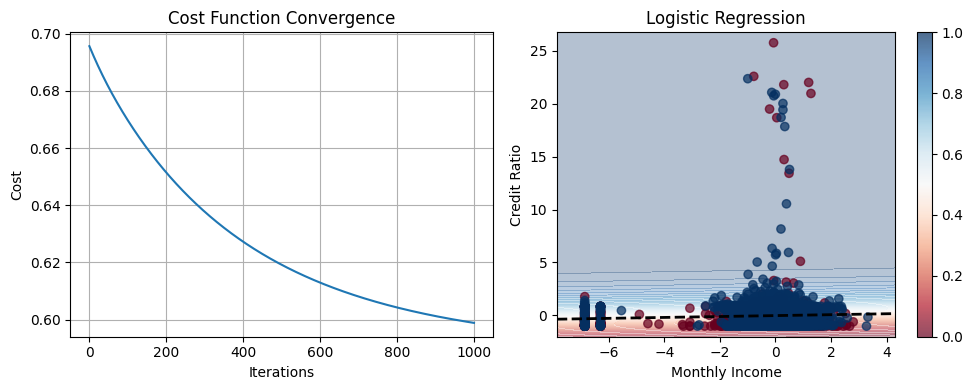

Accuracy:  0.7185
Precision: 0.7203
Recall:    0.7142
F1 Score:  0.7172


In [ ]:

def plot_decision_boundary_binary(X, y, theta, title="Decision Boundary"):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(cost_history_binary)
    plt.title('Cost Function Convergence')
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.grid(True)
    plt.subplot(1, 2, 2)

    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    mesh_points_with_intercept = add_intercept(mesh_points)
    Z = sigmoid(mesh_points_with_intercept.dot(theta))
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, levels=50, alpha=0.3, cmap='RdBu')
    plt.contour(xx, yy, Z, levels=[0.5], colors='black', linestyles='--', linewidths=2)

    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='RdBu', alpha=0.7)
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel('Monthly Income')
    plt.ylabel('Credit Ratio')

    plt.tight_layout()
    plt.show()

plot_decision_boundary_binary(X_binary_scaled, y_binary, theta_binary,
                            "Logistic Regression")

X_binary_with_intercept = add_intercept(X_binary_scaled)
probabilities = sigmoid(X_binary_with_intercept.dot(theta_binary))
predictions = (probabilities >= 0.5).astype(int)

accuracy = accuracy_score(y_binary, predictions)

accuracy = accuracy_score(y_binary, predictions)
precision = precision_score(y_binary, predictions)
recall = recall_score(y_binary, predictions)
f1 = f1_score(y_binary, predictions)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")